# Group members
- Bui Huy Giap - 23127289
- Le Minh Duc - 23127351
- Vu Tien Dung - 23127354
- Dinh Xuan Khuong - 23127398
- Nguyen Dong Thanh - 23127538

# 0. Import our libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from joblib import dump
np.set_printoptions(suppress=True, precision=4)

# 1. Import data


Data source: https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction

In [2]:
# code here
data_path = "../data/medical_insurance.csv"
try:
    df = pd.read_csv(data_path)
    display(df.head())
except FileNotFoundError:
    print("Error: File not found")
except Exception as e:
    print(f"An error occurred: {e}")

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 2. Helper Functions


In [3]:
def hist_plot(feature, title: str, color: str, x_label: str = None, y_label : str = None):
    # Histograms for numerical variables
    plt.figure(figsize=(6,4))
    plt.hist(feature, color=color, edgecolor= 'black')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def bar_plot(feature, title: str):
    plt.figure(figsize=(6,4))
    
    counts = feature.value_counts()
    total = counts.sum()

    # mỗi cột 1 màu
    colors = plt.cm.tab20(range(len(counts)))

    ax = counts.plot(kind='bar', color=colors)

    # ghi tỷ lệ phần trăm trên từng cột
    for p in ax.patches:
        height = p.get_height()
        percent = height / total * 100
        ax.annotate(f'{percent:.1f}%',
                    (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)

    plt.title(title)
    plt.xlabel(feature.name)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


def compare_output(y_pred, y_true):
    plt.figure(figsize=(20,8))
    plt.plot(y_pred, c='orange', label='Predicted Charges')
    plt.plot(y_true, c='blue', label='True Charges')
    plt.xlabel("Index")
    plt.ylabel("Charges")
    plt.legend(loc='best')  # automatically chooses the best place
    plt.title("Comparison of Predicted vs True Charges")
    plt.show()
    
def scatter_mean(df, x_name: str, y_name: str):
    sns.scatterplot(x = x_name, y = y_name, data=df, alpha=0.6)

    mean_df = df.groupby(x_name, as_index=False)[y_name].mean()

    sns.lineplot(x = x_name, y = y_name, data=mean_df, color="red", linewidth=2)

    plt.title(f"Scatter plot of {x_name} and {y_name} with mean line")
    plt.show()

def scatter_mean_regression(df, x_name, y_name, bins=10):
    df_copy = df.copy()

    df_copy["x_bin"] = pd.cut(df_copy[x_name], bins=bins)

    mean_df = df_copy.groupby("x_bin", observed=True, as_index=False)[y_name].mean()

    mean_df["x_center"] = mean_df["x_bin"].apply(lambda x: x.mid)

    sns.scatterplot(x=x_name, y=y_name, data=df_copy, alpha=0.4)
    sns.lineplot(x="x_center", y=y_name, data=mean_df, color="red", linewidth=2, marker="o")

    plt.title(f"Scatter plot of {x_name} and {y_name} with mean line")
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()


def plot_scatter(y_true, y_pred):
    error = np.abs(np.array(y_true) - np.array(y_pred))

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(y_true, y_pred, c=error, cmap="coolwarm")
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.title("Scatter plot: y_true vs y_pred (colored by error)")
    plt.colorbar(scatter, label="Absolute Error")
    plt.grid(True)
    plt.show()


# 3. Exploratory Data Analysis (EDA)

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


There are 2772 rows and 7 columns in total.

In [6]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
list(set(df['region']))

['southeast', 'southwest', 'northeast', 'northwest']

In [8]:
list(set(df['smoker']))

['no', 'yes']

In [9]:
list(set(df['sex']))

['female', 'male']

### Meaning of each column

| Column       | Meaning                                                                                                                                 |
| ------------ | --------------------------------------------------------------------------------------------------------------------------------------- |
| **age**      | Age of the individual (in years).                                 |
| **sex**      | Gender of the individual (male or female). |
| **bmi**      | Body Mass Index of the individual (a measure of body fat based on height/weight).                         |
| **children** | Number of children/dependents the individual has.                                                                  |
| **smoker**   | Whether the individual is a smoker (“yes” if they smoke, “no” if they don’t).                                     |
| **region**   | The geographic region where the individual lives (e.g., northeast, northwest, southeast, southwest in the US context).  |
| **charges**  | The medical insurance cost or charges for the individual (target variable in the dataset).                   |



## Duplicate checking

In [10]:
df.duplicated().sum()

1435

In [11]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [12]:
dups = df[df.duplicated(keep=False)]
dups


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


Some columns that are duplicated

In [13]:
dups.groupby(df.columns.tolist()).size()

age  sex     bmi     children  smoker  region     charges    
18   female  20.790  0         no      southeast  1607.51010     2
             21.660  0         yes     northeast  14283.45940    2
             24.090  1         no      southeast  2201.09710     2
             25.080  0         no      northeast  2196.47320     2
             26.315  0         no      northeast  2198.18985     2
                                                                ..
64   male    36.960  2         yes     southeast  49577.66240    4
             37.905  0         no      northwest  14210.53595    2
             38.190  0         no      northeast  14410.93210    2
             39.160  1         no      southeast  14418.28040    2
             40.480  0         no      southeast  13831.11520    2
Length: 1337, dtype: int64

## 3.1 Data Cleaning 

### 3.1.1 Missing values

#### a. Handle missing values

In [14]:
df.isnull().sum() # Don't have missing values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### b. Handle duplicate values 

In [15]:
df = df.drop_duplicates().reset_index(drop=True)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


In [16]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


## 3.2 Distribution of each feature

In [17]:
categorical_cols = ["sex", "children", "smoker", "region"]
continuous_cols = [name for name in df.columns.to_list() if name not in  categorical_cols]
continuous_cols, categorical_cols


(['age', 'bmi', 'charges'], ['sex', 'children', 'smoker', 'region'])

### Categorical columns

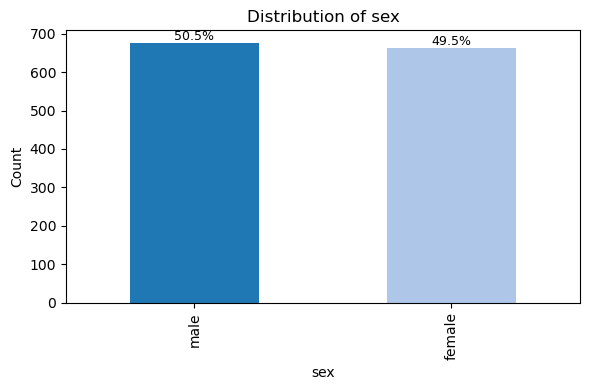

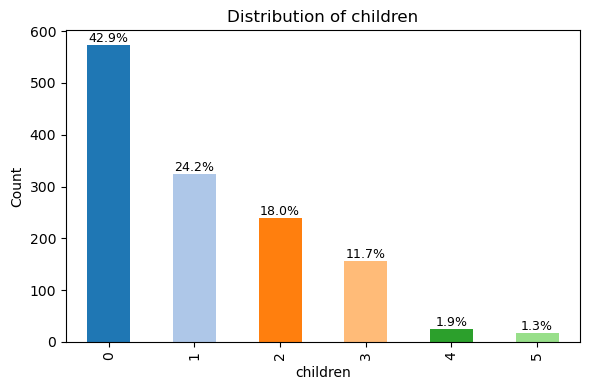

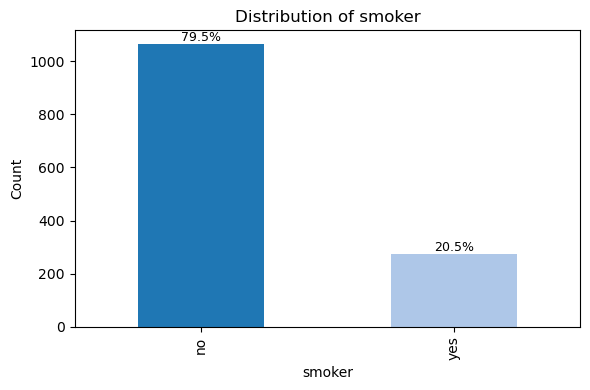

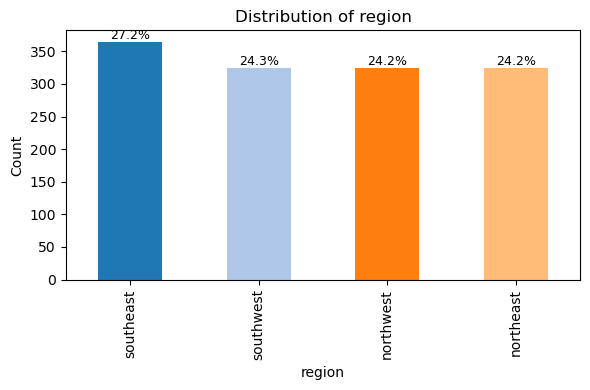

In [18]:
for name in categorical_cols:
    bar_plot(df[name], f"Distribution of {name}")

### Continuous columns

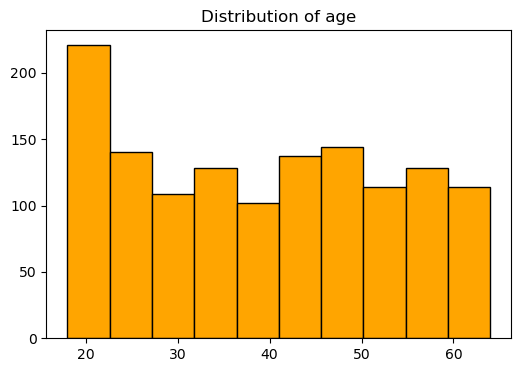

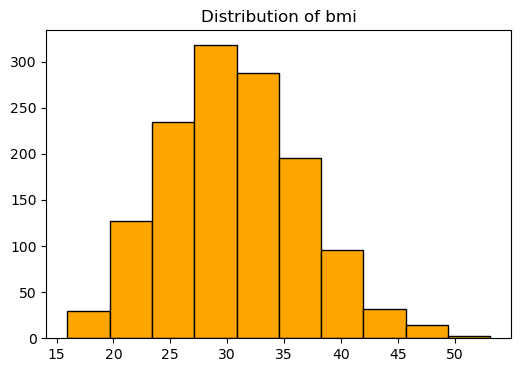

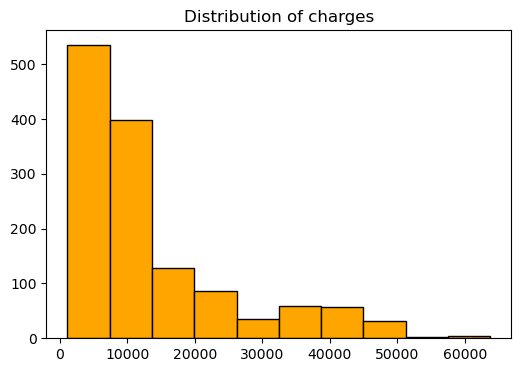

In [19]:
for name in continuous_cols:
    hist_plot(df[name], f"Distribution of {name}", "orange")

## 3.3 Data Pre-Processing   

### 3.3.1 One-hot Encoding

In [20]:
def encode_categorical(data):
    data = data.copy()
    # Perform one-hot encoding
    one_hot_sex = pd.get_dummies(data['sex'], dtype=int, drop_first=True)
    one_hot_smoker = pd.get_dummies(data['smoker'], dtype=int, drop_first=True)
    one_hot_region = pd.get_dummies(data['region'], dtype=int, drop_first=False)

    # Concatenate the one-hot encoded columns with the original DataFrame
    df_encoded = pd.concat([data.iloc[:, :-1], one_hot_region, data.iloc[:, -1]], axis=1)
    df_encoded.drop(columns=['region'], inplace=True)
    df_encoded['sex'] = one_hot_sex
    df_encoded['smoker'] = one_hot_smoker

    return df_encoded

In [21]:
encode_df = encode_categorical(df)
encode_df.head()

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest,charges
0,19,0,27.900,0,1,0,0,0,1,16884.92400
1,18,1,33.770,1,0,0,0,1,0,1725.55230
2,28,1,33.000,3,0,0,0,1,0,4449.46200
3,33,1,22.705,0,0,0,1,0,0,21984.47061
4,32,1,28.880,0,0,0,1,0,0,3866.85520


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


We can see that there is no null value in our dataframe

## 3.4 Relationship Exploring

##### 3.4.1 Scatter plot with average line

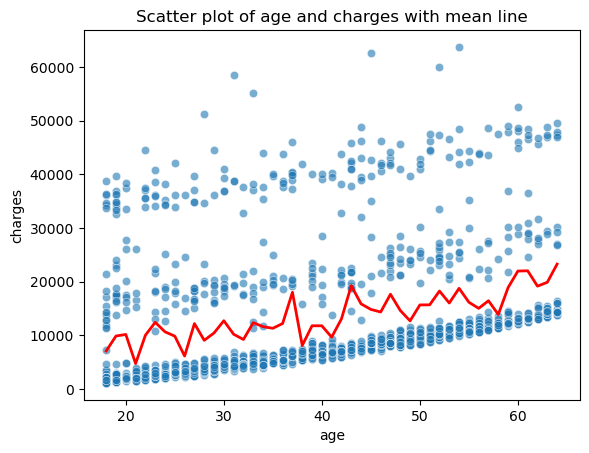

In [23]:
scatter_mean(df, "age", "charges")

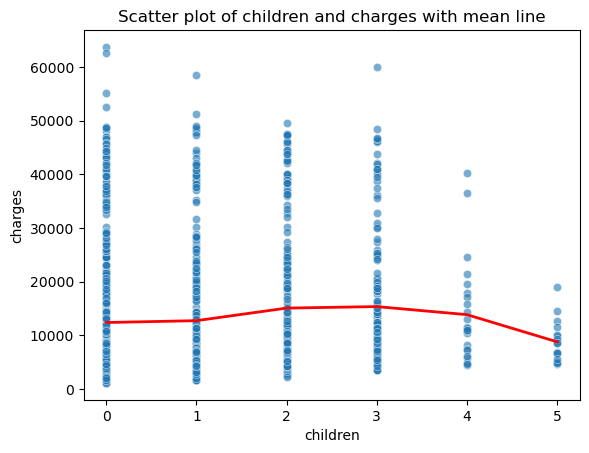

In [24]:
scatter_mean(df, "children", "charges")

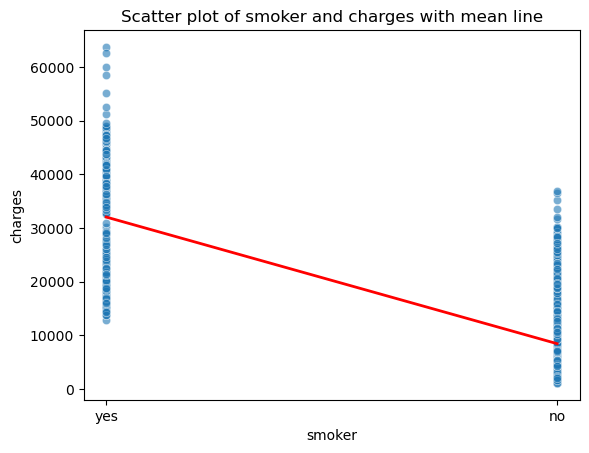

In [25]:
scatter_mean(df, "smoker", "charges")

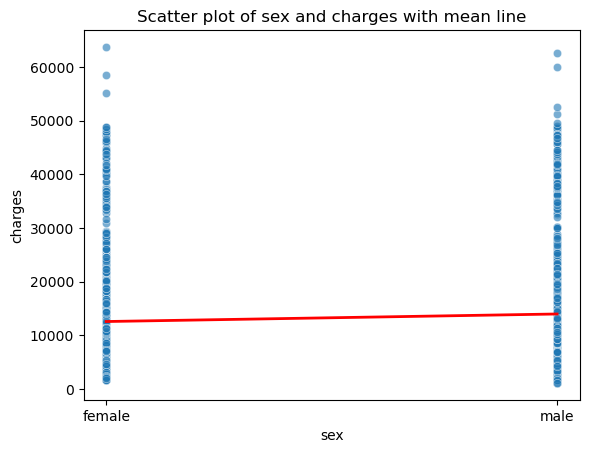

In [26]:
scatter_mean(df, "sex", "charges")

In [27]:
column_names = df.columns.to_list()
column_names

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

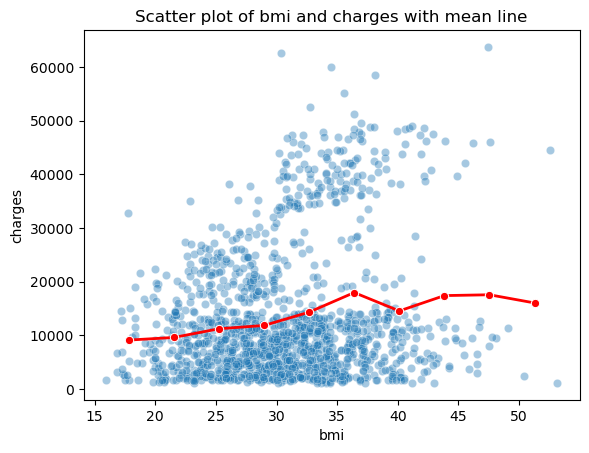

In [28]:
scatter_mean_regression(df, "bmi", "charges")

In [29]:
encode_df

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest,charges
0,19,0,27.900,0,1,0,0,0,1,16884.92400
1,18,1,33.770,1,0,0,0,1,0,1725.55230
2,28,1,33.000,3,0,0,0,1,0,4449.46200
3,33,1,22.705,0,0,0,1,0,0,21984.47061
4,32,1,28.880,0,0,0,1,0,0,3866.85520
...,...,...,...,...,...,...,...,...,...,...
1332,50,1,30.970,3,0,0,1,0,0,10600.54830
1333,18,0,31.920,0,0,1,0,0,0,2205.98080
1334,18,0,36.850,0,0,0,0,1,0,1629.83350
1335,21,0,25.800,0,0,0,0,0,1,2007.94500


##### 3.4.2 Correlation Matrix

In [30]:
def plot_heatmap(df, columns=None, cmap='coolwarm', title='Correlation Matrix'):
    corr = df[columns].corr() if columns else df.corr()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(range(len(corr.columns)), corr.columns)

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            value = corr.iloc[i, j]
            plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

    plt.title(title)
    plt.show()

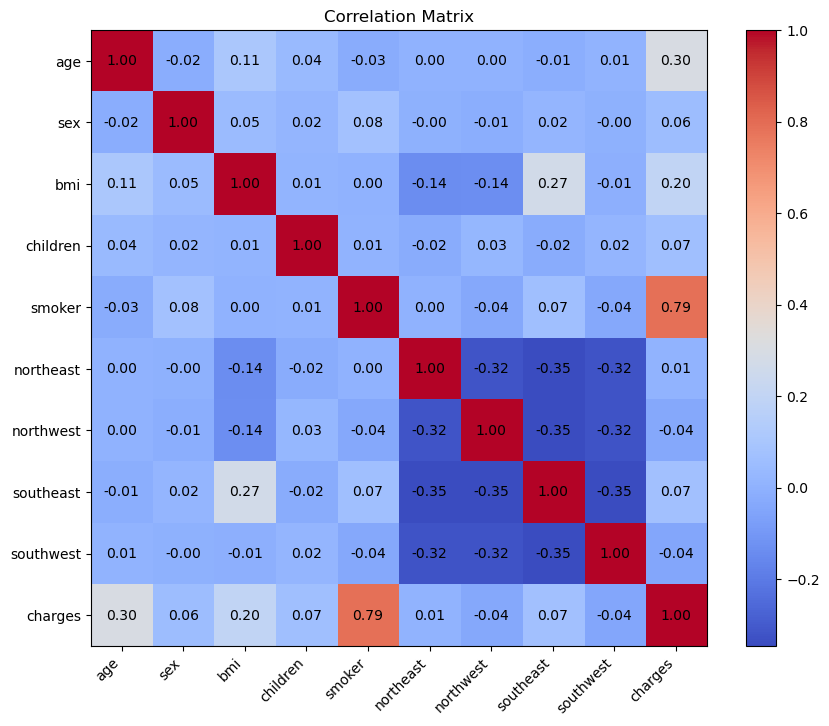

In [31]:
plot_heatmap(encode_df)

# 4. Building models


Import important libraries for this part:


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures

In [33]:
X = encode_df.drop(["charges"],axis=1)
y = encode_df["charges"].reset_index(drop=True)
y = y.to_numpy()

In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(962, 962, 107, 107, 268, 268)

#### Model 1: All features without standarization (baseline model)

In [35]:
X_train_val_numpy = X_train_val.to_numpy()

In [36]:
X_train_numpy = X_train.to_numpy()
y_train_numpy = y_train

In [37]:
X_test_numpy, y_test_numpy = X_test.to_numpy(), y_test
X_valid_numpy, y_valid_numpy = X_val.to_numpy(), y_val

In [38]:
model_1 = LinearRegression() # Automatically add bias column

model_1.fit(X_train_val_numpy, y_train_val) # use both training and validation set for training to get better result
y_predicted = model_1.predict(X_test_numpy)

mse_all_features = mean_squared_error(y_test_numpy, y_predicted)
mae_all_features = mean_absolute_error(y_test_numpy, y_predicted)

print("MSE: ", mse_all_features)
print("MAE: ", mae_all_features)

MSE:  35478020.675235584
MAE:  4177.045561036316


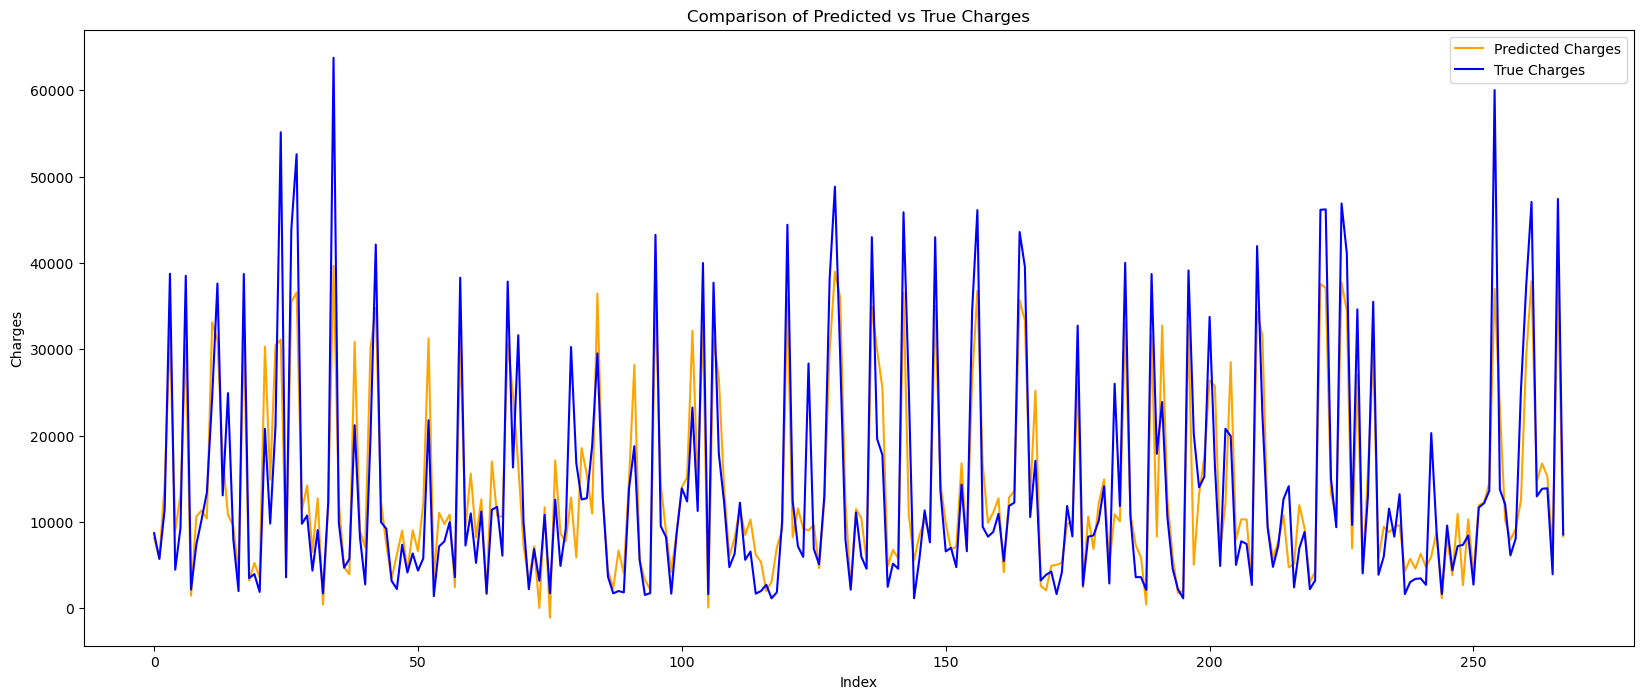

In [39]:
compare_output(y_predicted, y_test_numpy)

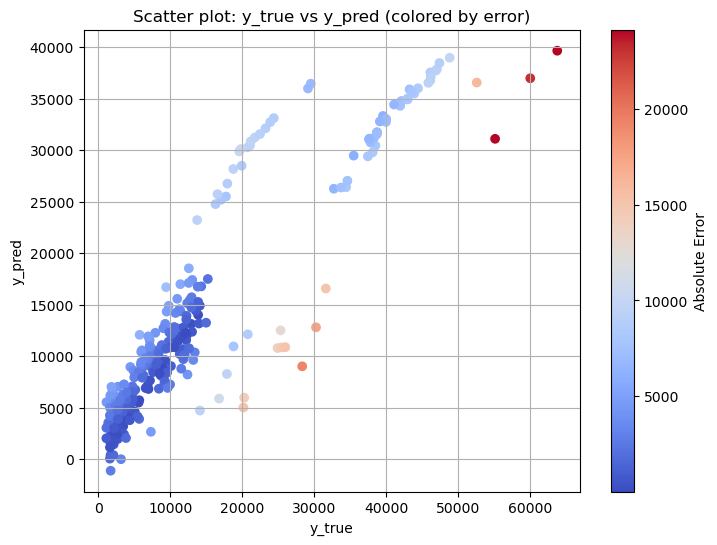

In [40]:
plot_scatter(y_test_numpy, y_predicted)

#### Model 2: smoker, age, bmi

We choose 3 features with highest correlation with `Charges`

In [41]:
# use both training and validation set for training to get better result
X_train_smoke_age_bmi = X_train_val[["smoker", "age", "bmi"]].to_numpy()
X_test_smoke_age_bmi = X_test[["smoker", "age", "bmi"]].to_numpy()

In [42]:
model_2 = LinearRegression()
model_2.fit(X_train_smoke_age_bmi, y_train_val) 
y_predicted = model_2.predict(X_test_smoke_age_bmi)

mse_3_features = mean_squared_error(y_test_numpy, y_predicted)
mae_3_features = mean_absolute_error(y_test_numpy, y_predicted)

print("MSE: ", mse_3_features)
print("MAE: ", mae_3_features)

MSE:  35841574.81814752
MAE:  4191.704294603893


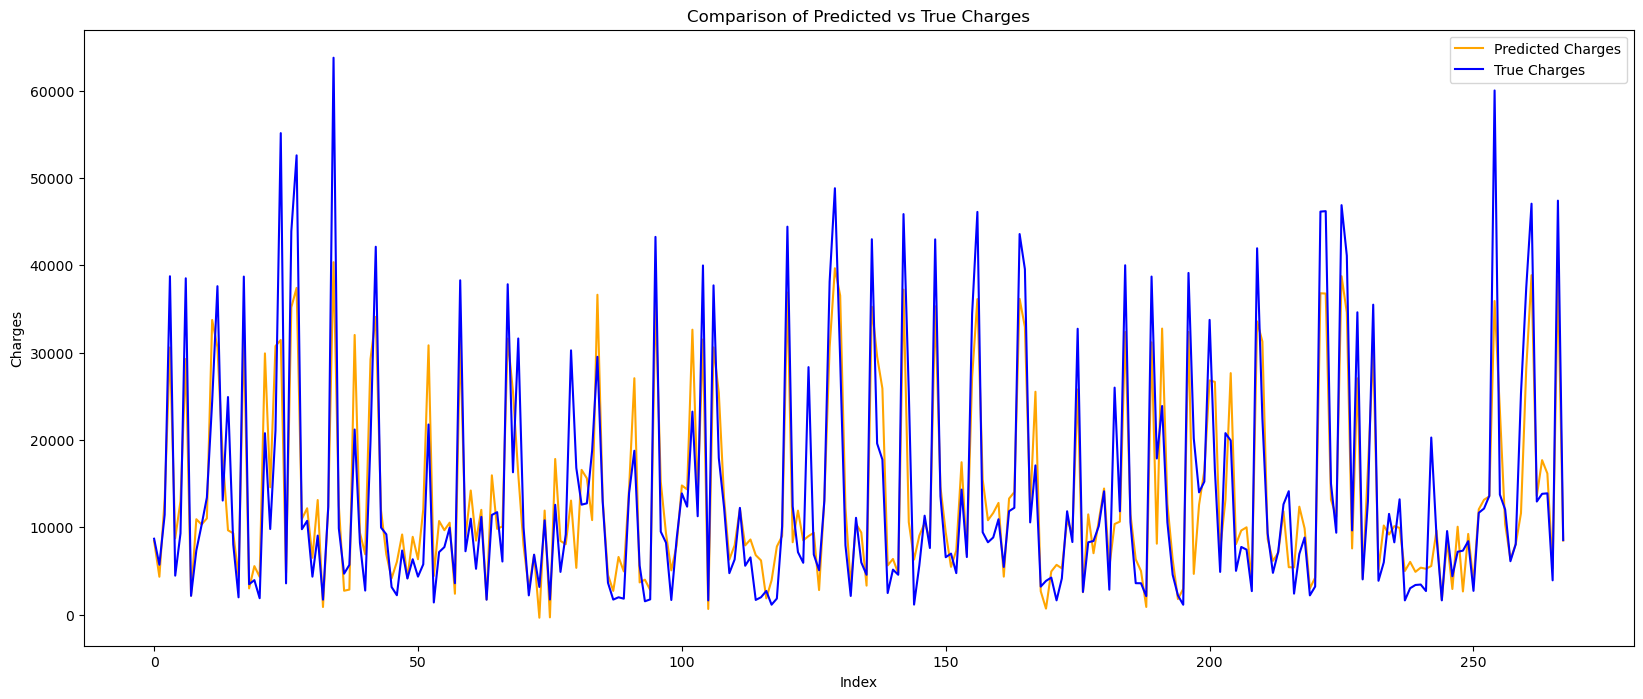

In [43]:
compare_output(y_predicted, y_test_numpy)

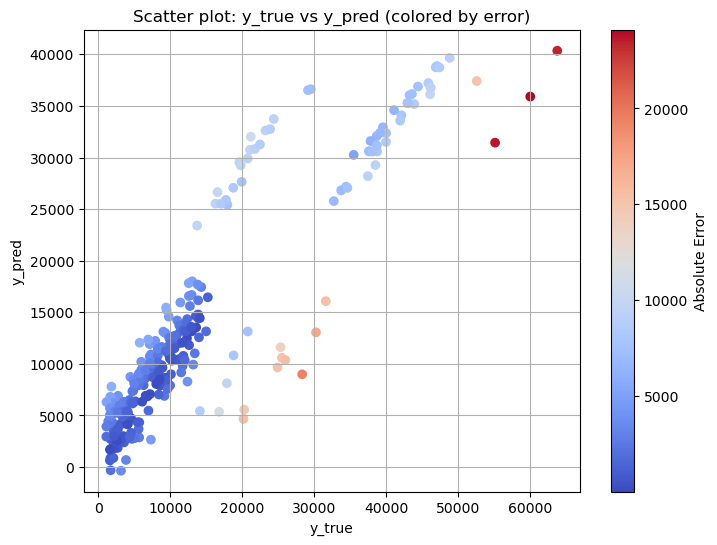

In [44]:
plot_scatter(y_test_numpy, y_predicted)

#### Model 3: smoker, age, bmi, children, sex

In [45]:
X_train_5_features = X_train_val[["smoker", "age", "bmi", 'children', 'sex']].to_numpy()
X_test_5_features = X_test[["smoker", "age", "bmi", 'children', 'sex']].to_numpy()

In [46]:
model_3 = LinearRegression()
model_3.fit(X_train_5_features, y_train_val)
y_predicted = model_3.predict(X_test_5_features)

mse_5_features = mean_squared_error(y_test_numpy, y_predicted)
mae_5_features = mean_absolute_error(y_test_numpy, y_predicted)

print("MSE:", mse_5_features)
print("MAE:", mae_5_features)

MSE: 35901914.114619814
MAE: 4198.1118004745995


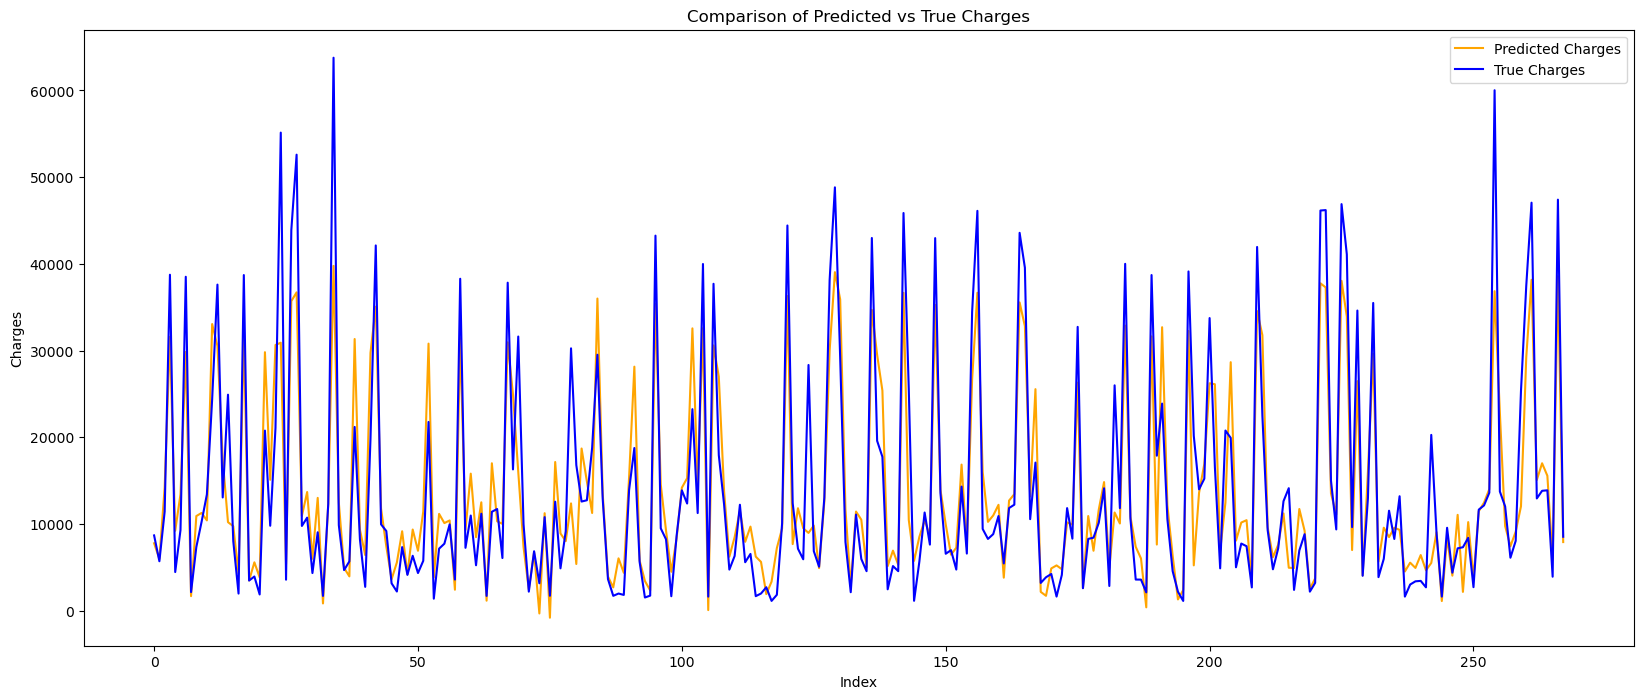

In [47]:
compare_output(y_predicted, y_test_numpy)

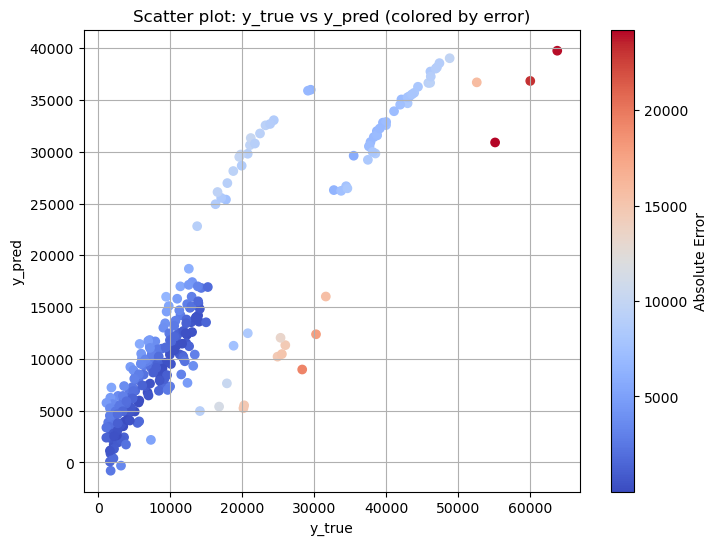

In [48]:
plot_scatter(y_test_numpy, y_predicted)

#### Model 4: Ridge regression 

In [49]:
# Preprocessing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numpy)
X_valid_scaled = scaler.transform(X_valid_numpy)
X_test_scaled  = scaler.transform(X_test_numpy)

X_trainval = np.concatenate([X_train_scaled, X_valid_scaled])
y_trainval = np.concatenate([y_train, y_valid_numpy])

In [50]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100] # lambda
param_grid = {'alpha': alphas} 

grid = GridSearchCV(estimator=Ridge(), param_grid=param_grid,
                    cv=5, scoring='neg_mean_squared_error')
grid.fit(X_trainval, y_trainval)

best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)

ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_trainval, y_trainval)

y_predicted = ridge_model.predict(X_test_scaled)

mse_ridge = mean_squared_error(y_test_numpy, y_predicted)
mae_ridge = mean_absolute_error(y_test_numpy, y_predicted)

print(mse_ridge)
print(mae_ridge)

Best alpha: 10
35826718.50304947
4202.594196432237


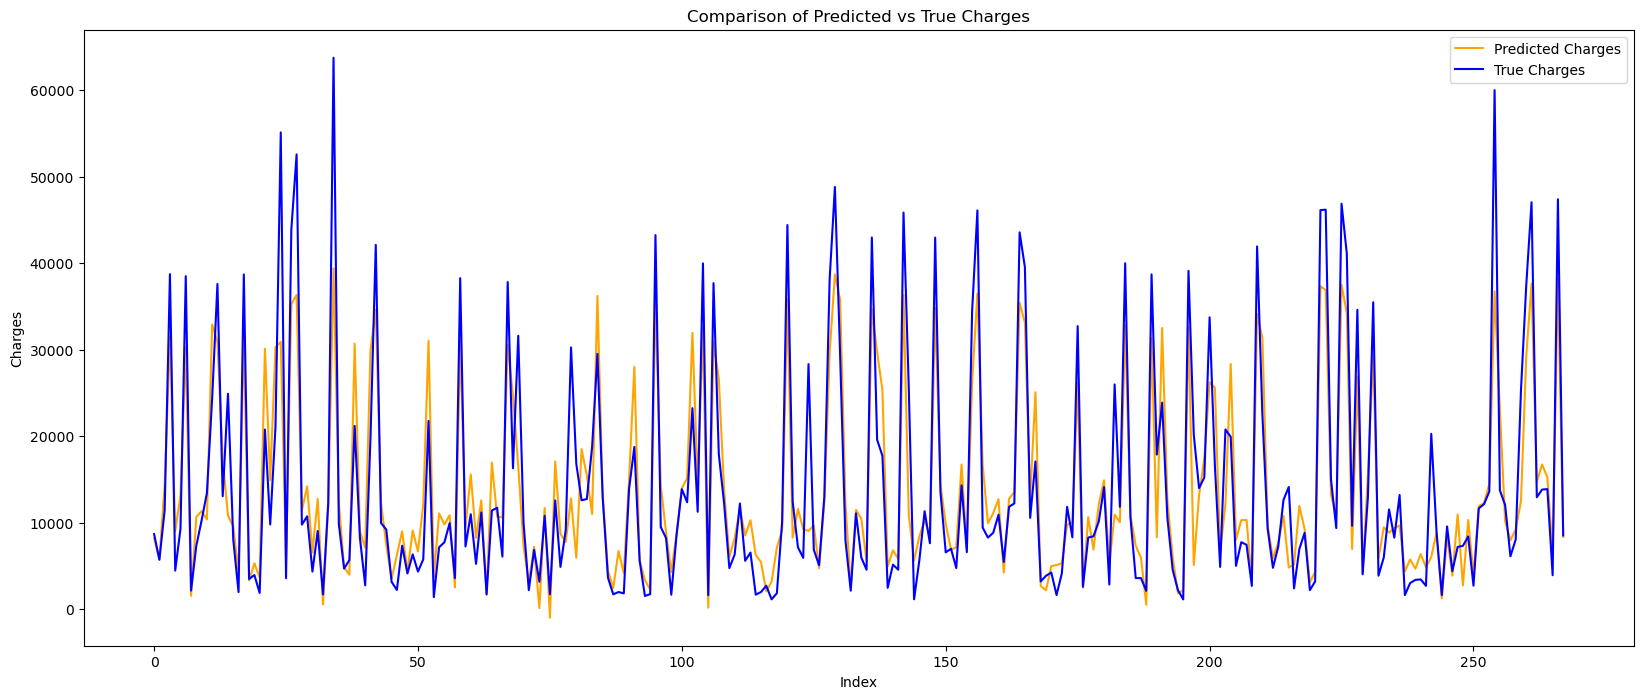

In [51]:
compare_output(y_pred=y_predicted, y_true=y_test_numpy)

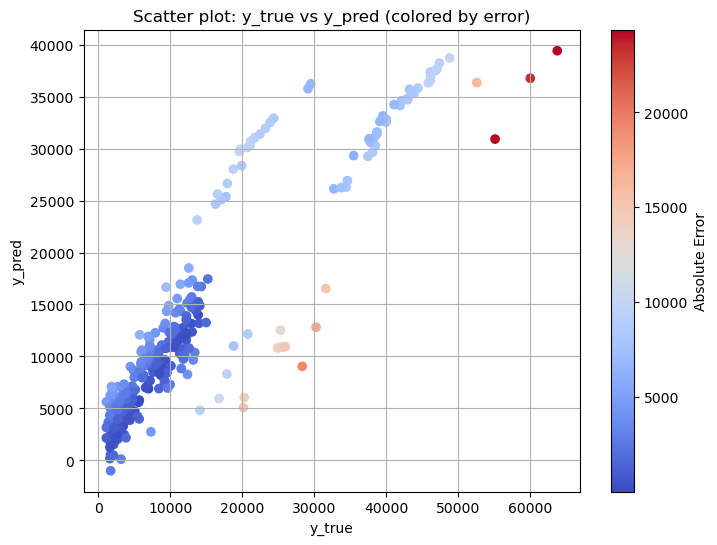

In [52]:
plot_scatter(y_test_numpy, y_predicted)

#### Model 5: Lasso regression
* L1 norm
* Dùng Grid search để tìm hyperparameter lambda tối ưu nhất
* Trong Lasso có biến intercept (bias)

In [53]:
# Preprocessing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numpy)
X_valid_scaled = scaler.transform(X_valid_numpy)
X_test_scaled  = scaler.transform(X_test_numpy)

X_trainval = np.concatenate([X_train_scaled, X_valid_scaled])
y_trainval = np.concatenate([y_train, y_valid_numpy])


In [54]:

alphas = [0.001, 0.01, 0.1, 1, 10, 100] # lambda
param_grid = {'alpha': alphas} 

grid = GridSearchCV(estimator=Lasso(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_trainval, y_trainval)

best_alpha = grid.best_params_['alpha']
print("Best lambda:", best_alpha)

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_trainval, y_trainval)

y_predicted = lasso_model.predict(X_test_scaled)

mse_lasso = mean_squared_error(y_test_numpy, y_predicted)
mae_lasso = mean_absolute_error(y_test_numpy, y_predicted)

print(f"MSE: {mse_lasso}")
print(f"MAE: {mae_lasso}")

Best lambda: 100
MSE: 36258685.488026485
MAE: 4199.583871534138


/home/dxk/miniconda3/envs/min_ds-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.989e+08, tolerance: 1.158e+07
  model = cd_fast.enet_coordinate_descent(
/home/dxk/miniconda3/envs/min_ds-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+07, tolerance: 1.171e+07
  model = cd_fast.enet_coordinate_descent(
/home/dxk/miniconda3/envs/min_ds-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

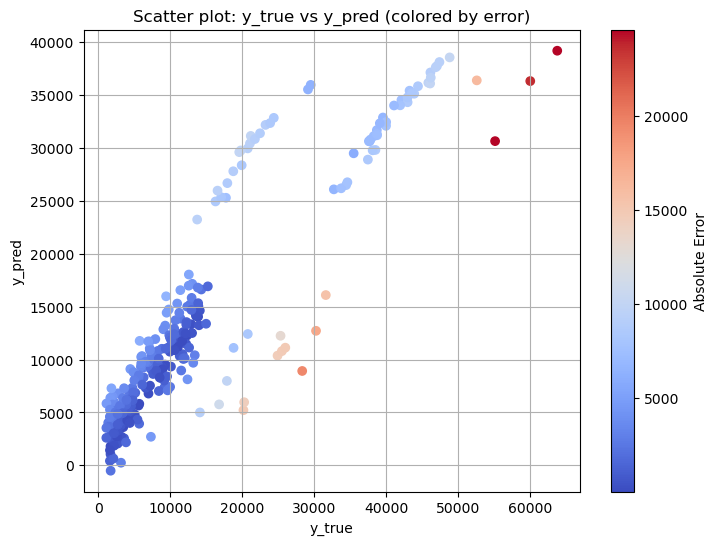

In [55]:
plot_scatter(y_test_numpy, y_predicted)

#### Model 6: Polynomial regression

In [56]:
# Preprocessing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numpy)
X_valid_scaled = scaler.transform(X_valid_numpy)
X_test_scaled  = scaler.transform(X_test_numpy)

X_trainval = np.concatenate([X_train_scaled, X_valid_scaled])
y_trainval = np.concatenate([y_train, y_valid_numpy])


In [57]:
poly = PolynomialFeatures(degree=2) # This work kinda good
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled) 

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_numpy)
y_predicted = model_poly.predict(X_test_poly)

mae = mean_absolute_error(y_test_numpy, y_predicted)
mse = mean_squared_error(y_test_numpy, y_predicted)

print("MAE: ", mae)
print("MSE: ", mse)

MAE:  2939.1060880186565
MSE:  21751826.10993847


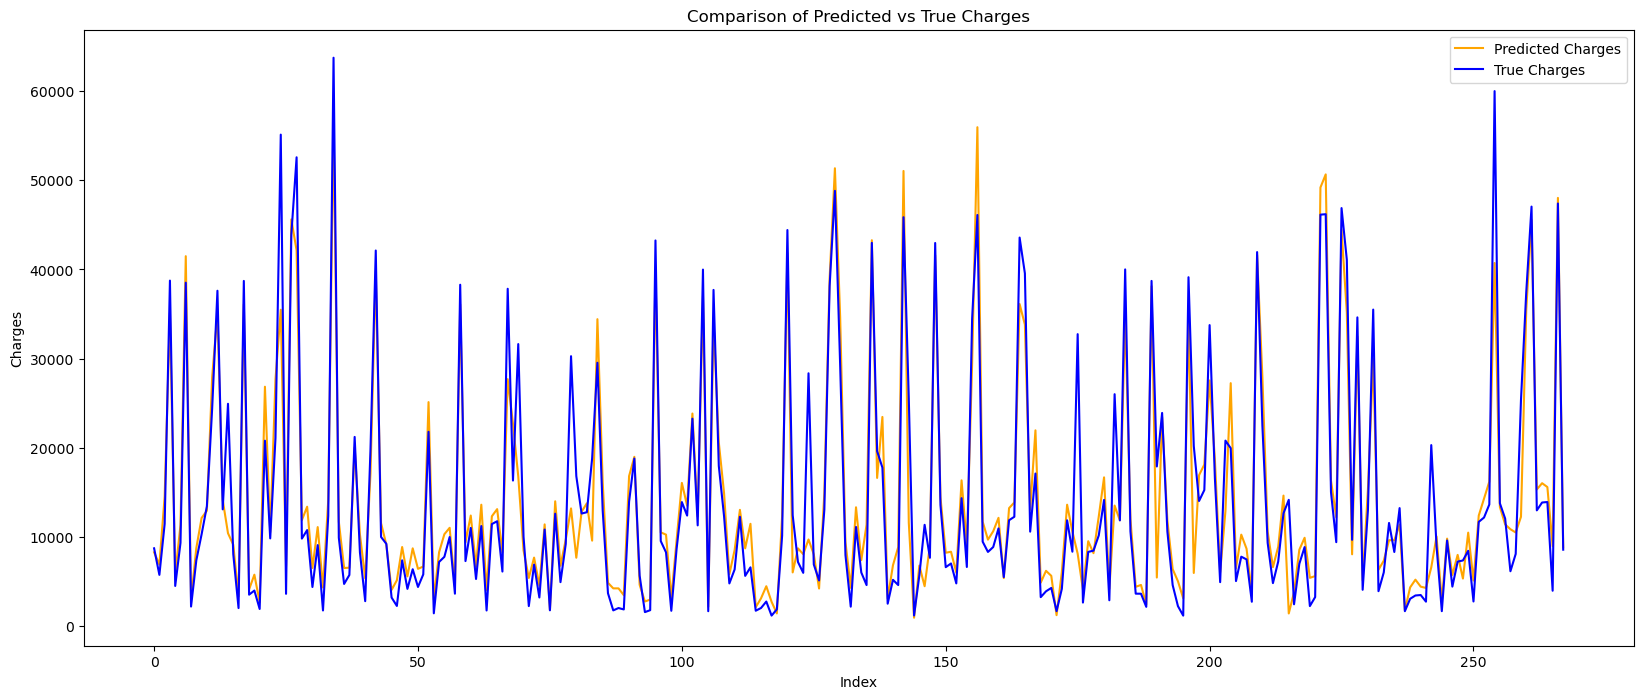

In [58]:
compare_output(y_pred=y_predicted, y_true=y_test_numpy)

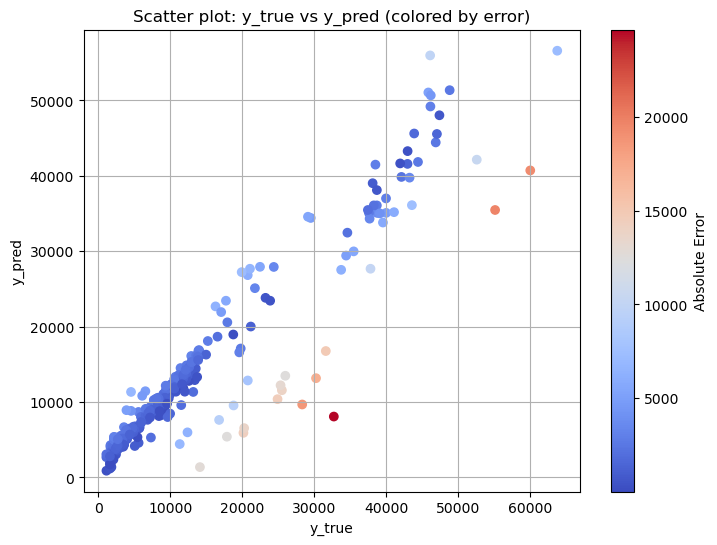

In [59]:
plot_scatter(y_test_numpy, y_predicted)

#### Model 7: Square of one feature

In [60]:
feature_name = 'bmi'
X_train_squared_feature = X_train.copy()
X_train_squared_feature[feature_name] **=2
X_train_squared_feature = X_train_squared_feature.to_numpy()

X_test_squared_feature = X_test.copy()
X_test_squared_feature[feature_name] **=2
X_test_squared_feature = X_test_squared_feature.to_numpy()

model_poly_linear = LinearRegression()
model_poly_linear.fit(X_train_squared_feature, y_train_numpy)
y_predicted_square_feature = model_poly_linear.predict(X_test_squared_feature)

mae = mean_absolute_error(y_test_numpy, y_predicted_square_feature)
mse = mean_squared_error(y_test_numpy, y_predicted_square_feature)

print("MAE: ", mae)
print("MSE: ", mse)

MAE:  4144.865193306942
MSE:  36086658.2875183


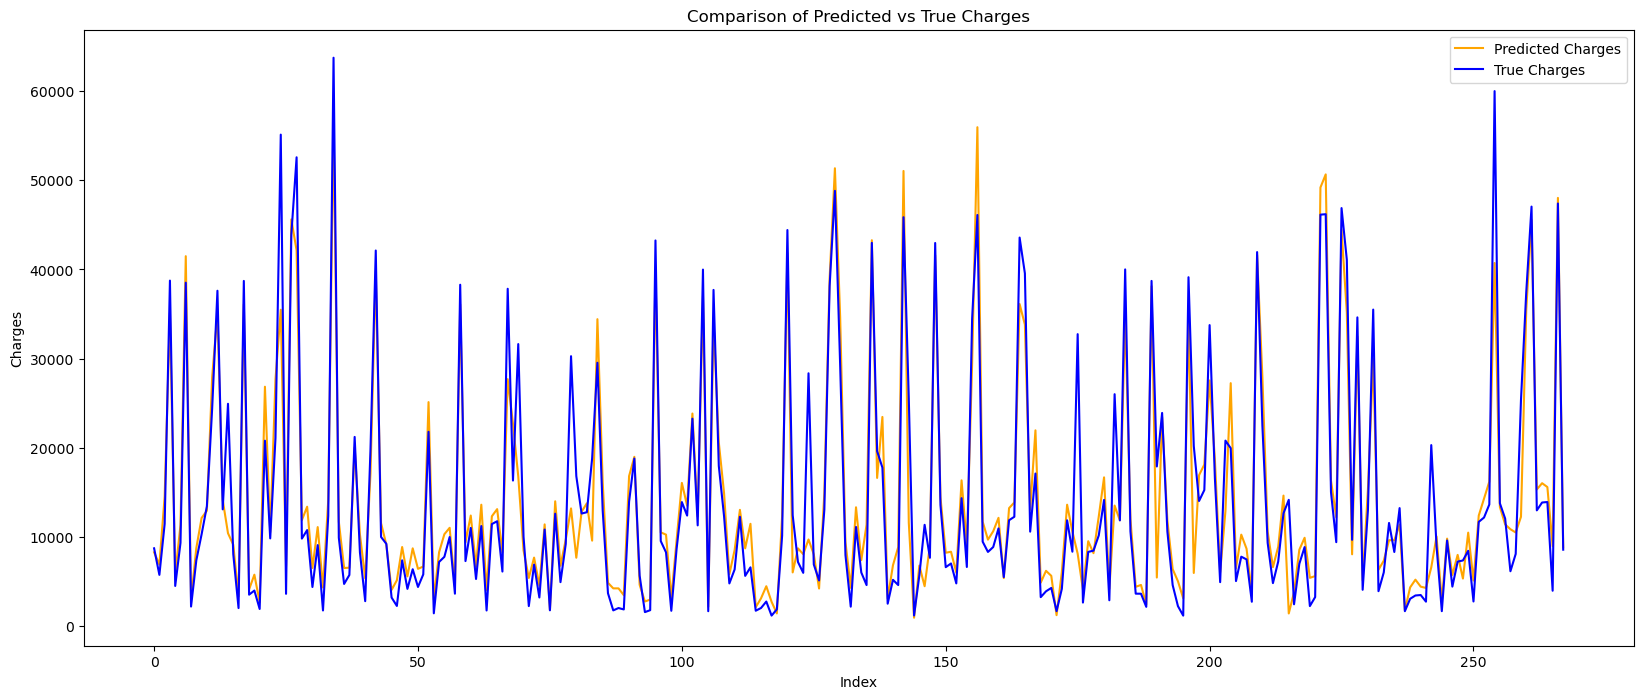

In [61]:
compare_output(y_pred=y_predicted, y_true= y_test_numpy)

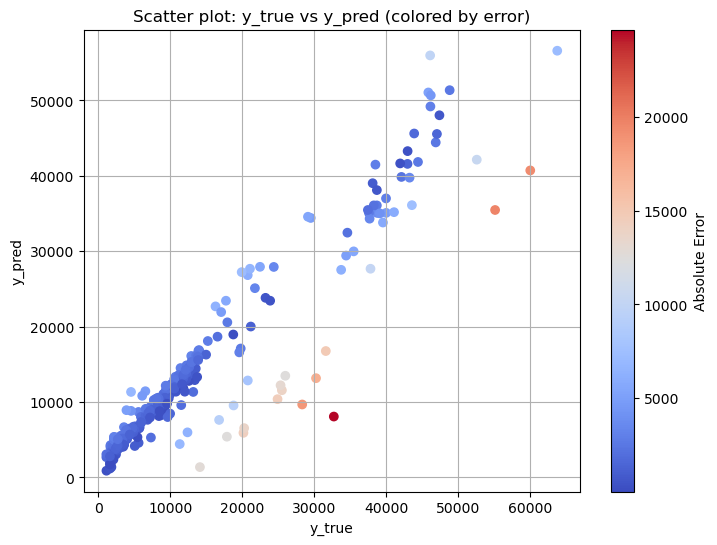

In [62]:
plot_scatter(y_test_numpy, y_predicted)

#### Model 8: Use 3 features with scaled Polynomial Features

In [63]:
X_train = X_train_val[["age", "bmi", "smoker"]]
X_test = X_test[["age", "bmi", "smoker"]]

# Build pipeline
pipeline_poly_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2)),
    ("model", LinearRegression())
])

pipeline_poly_3.fit(X_train, y_train_val)

y_pred = pipeline_poly_3.predict(X_test)


mae = mean_absolute_error(y_test_numpy, y_pred)
mse = mean_squared_error(y_test_numpy, y_pred)

print("MAE:", mae)
print("MSE:", mse)

MAE: 2817.2058570485074
MSE: 21399614.710343245


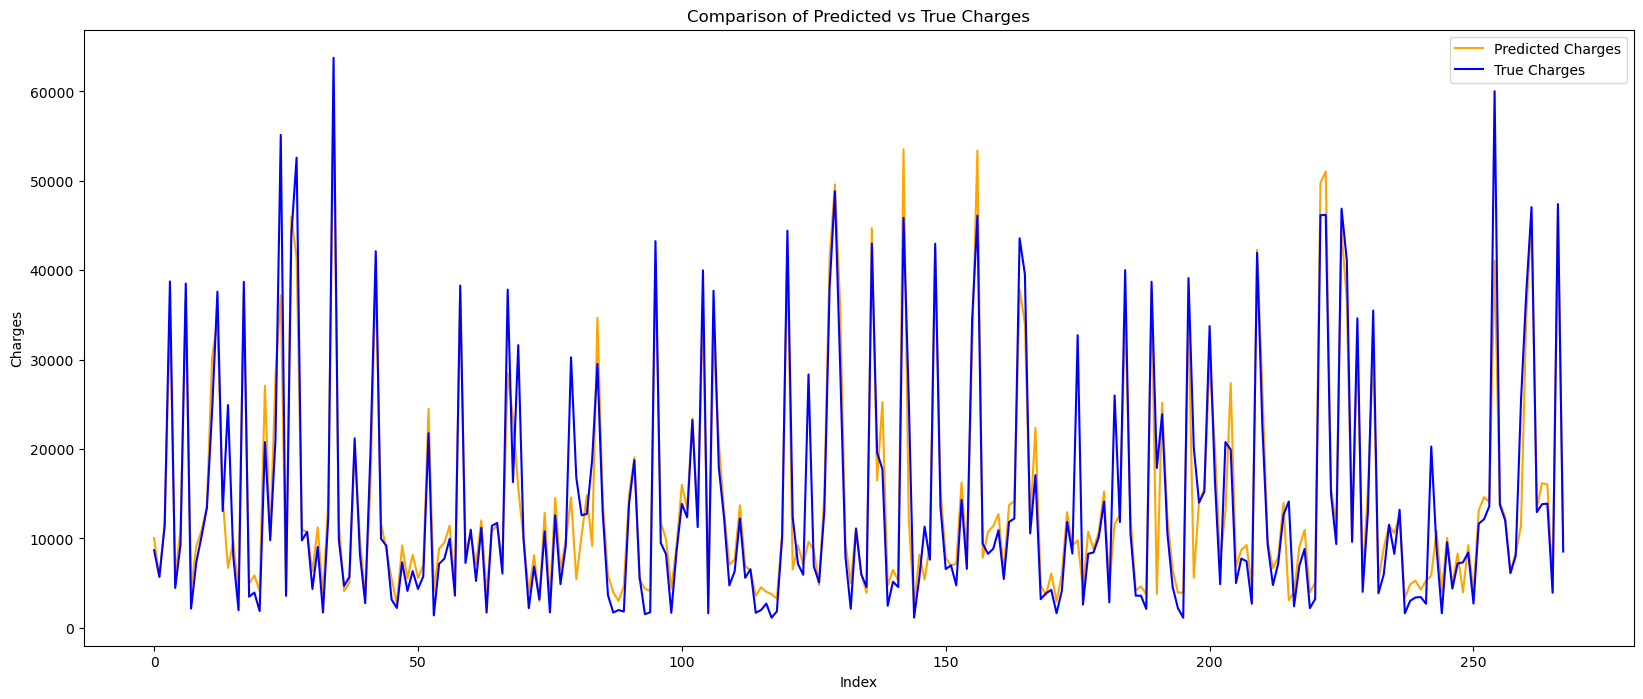

In [64]:
compare_output(y_pred=y_pred, y_true= y_test_numpy)

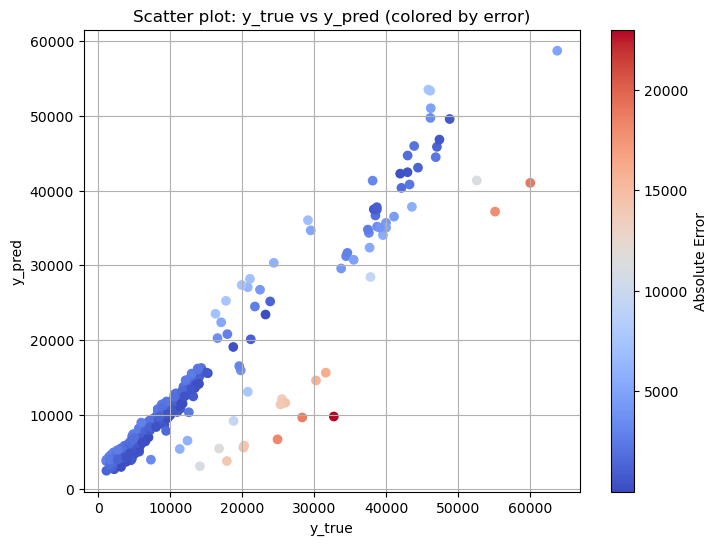

In [65]:
plot_scatter(y_test_numpy, y_pred)

# 5. Evaluate 

Base on 8 models that we trained before, the model with best performane is: `model_poly_3` with standardized data

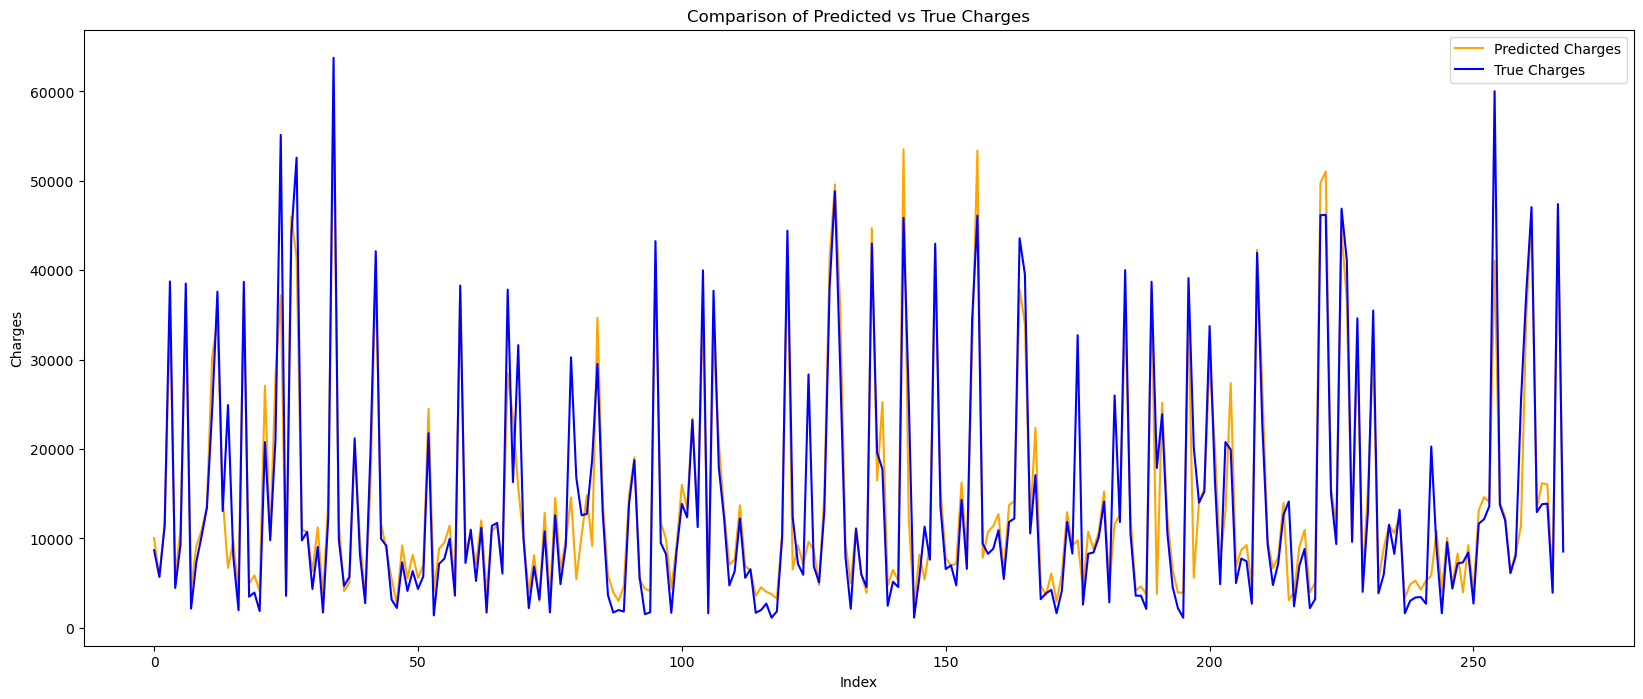

In [66]:
compare_output(y_pred=y_pred, y_true= y_test_numpy)

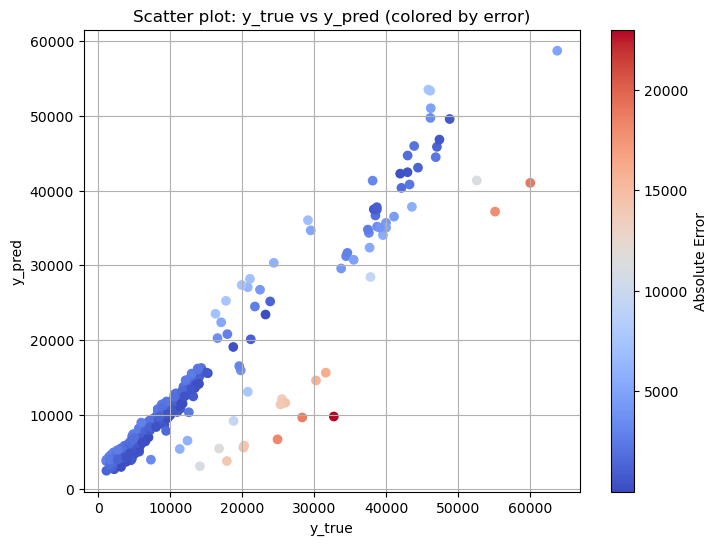

In [67]:
plot_scatter(y_test_numpy, y_pred)

#### Save model

In [68]:
dump(pipeline_poly_3, "poly_regression_pipeline.joblib")

['poly_regression_pipeline.joblib']

# 6. References

EDA\
https://www.kaggle.com/code/kenjee/titanic-project-example\
https://www.kaggle.com/code/veronikakachmar/medical-insurance-cost-prediction-and-eda\
https://www.kaggle.com/code/alyashoush/medical-insurance-cost-prediction\
https://www.geeksforgeeks.org/machine-learning/data-pre-processing-wit-sklearn-using-standard-and-minmax-scaler/


Scikit learn\
https://www.tutorialspoint.com/scikit_learn/scikit_learn_linear_regression.htm
https://www.tutorialspoint.com/scikit_learn/scikit_learn_ridge_regression.htm
https://www.tutorialspoint.com/scikit_learn/scikit_learn_lasso.htm
https://www.geeksforgeeks.org/machine-learning/python-implementation-of-polynomial-regression/
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


Joblib\
https://joblib.readthedocs.io/en/stable/generated/joblib.dump.html\
https://joblib.readthedocs.io/en/stable/generated/joblib.load.html